In [1]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia -p /content

!unzip /content/chest-xray-pneumonia.zip -d /content/chest-xray-pneumonia

Streaming output truncated to the last 5000 lines.
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: /content/chest-xray-pneumonia/chest_xray/

In [2]:
import os, shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
import skimage.segmentation
import cv2
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

In [13]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128


def get_data(data_dir):
  data = []
  for label in labels:
    path = os.path.join(data_dir, label)
    class_num = labels.index(label) # 0/1

    for img in os.listdir(path):
      try:
        img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
        if img_arr is None:
          continue #skip image if there is any issue
        resized_arr = cv2.resize(img_arr, (img_size, img_size))
        data.append([resized_arr, class_num])

      except Exception as e:
        print(f"Error in processing {img}: {e}")

  return data

In [14]:
train = get_data('/content/chest-xray-pneumonia/chest_xray/train')
test = get_data('/content/chest-xray-pneumonia/chest_xray/test')
val = get_data('/content/chest-xray-pneumonia/chest_xray/val')

In [16]:
pnuemonia = os.listdir("/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA")
pnuemonia_dir = "/content/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"

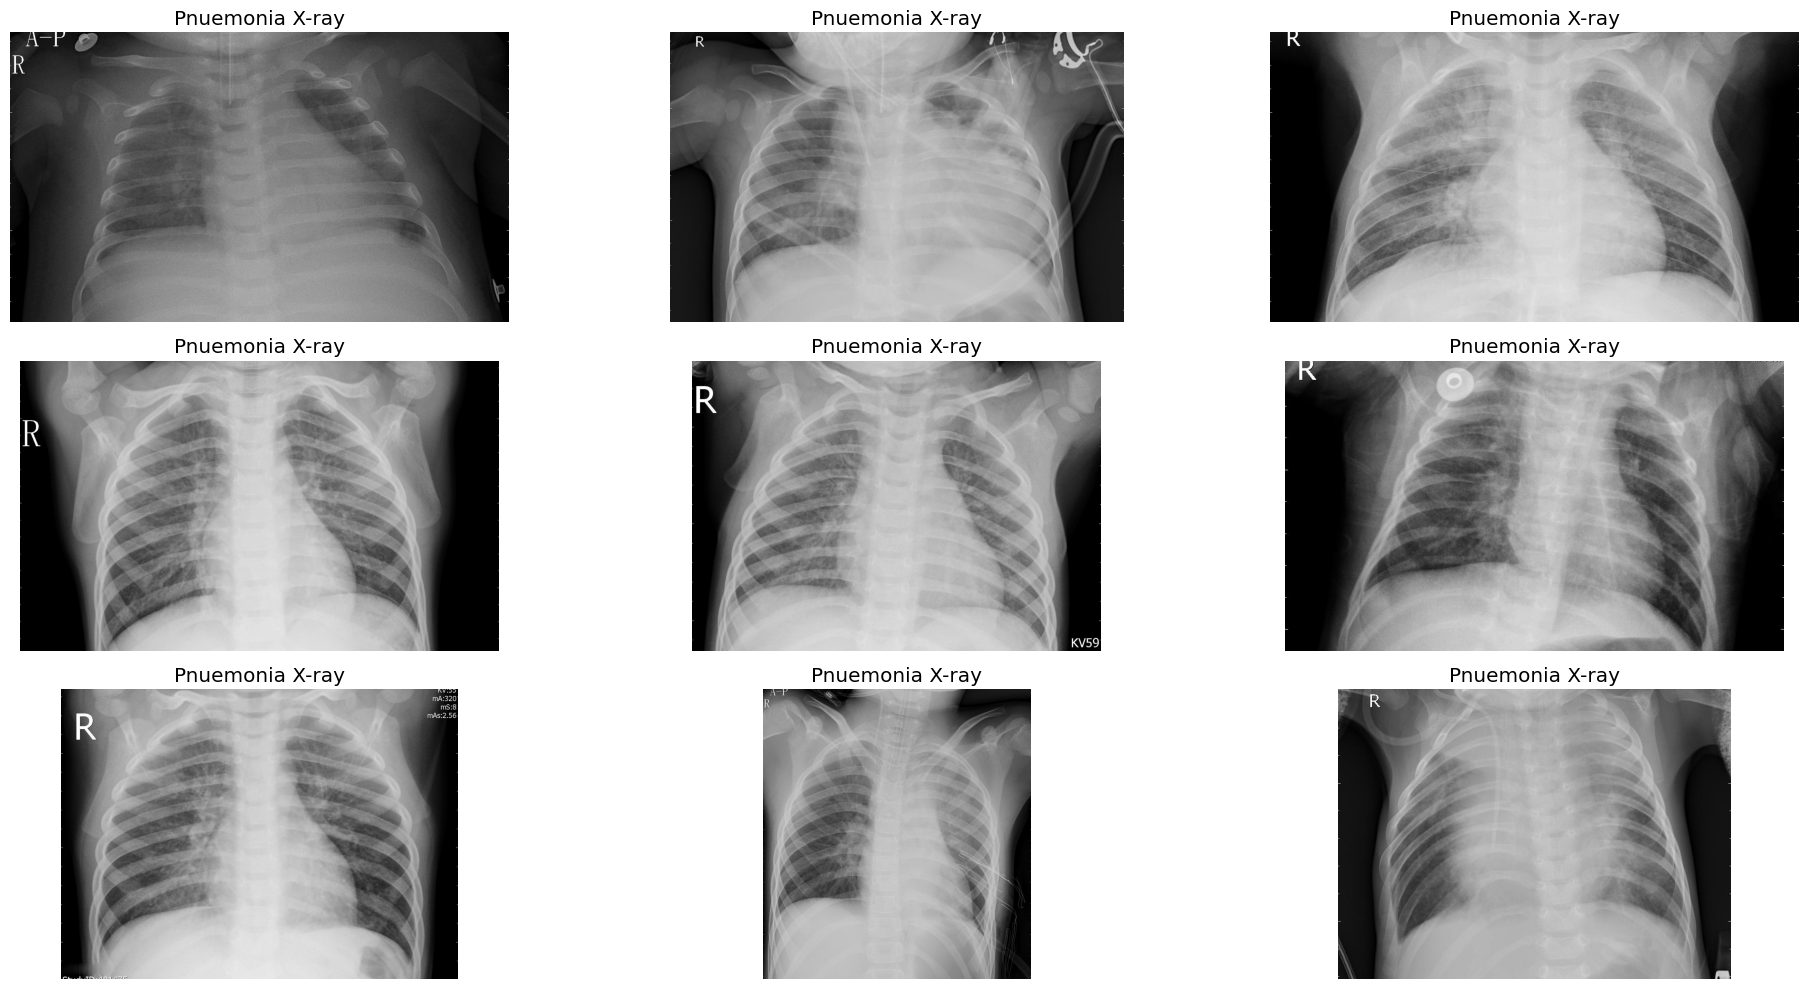

In [17]:
plt.figure(figsize=(20, 10))

for i in range(9):
  plt.subplot(3, 3, i+1)
  img = plt.imread(os.path.join(pnuemonia_dir, pnuemonia[i]))
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title("Pnuemonia X-ray")

plt.tight_layout()

In [18]:
normal = os.listdir("/content/chest-xray-pneumonia/chest_xray/train/NORMAL")
normal_dir = "/content/chest-xray-pneumonia/chest_xray/train/NORMAL"

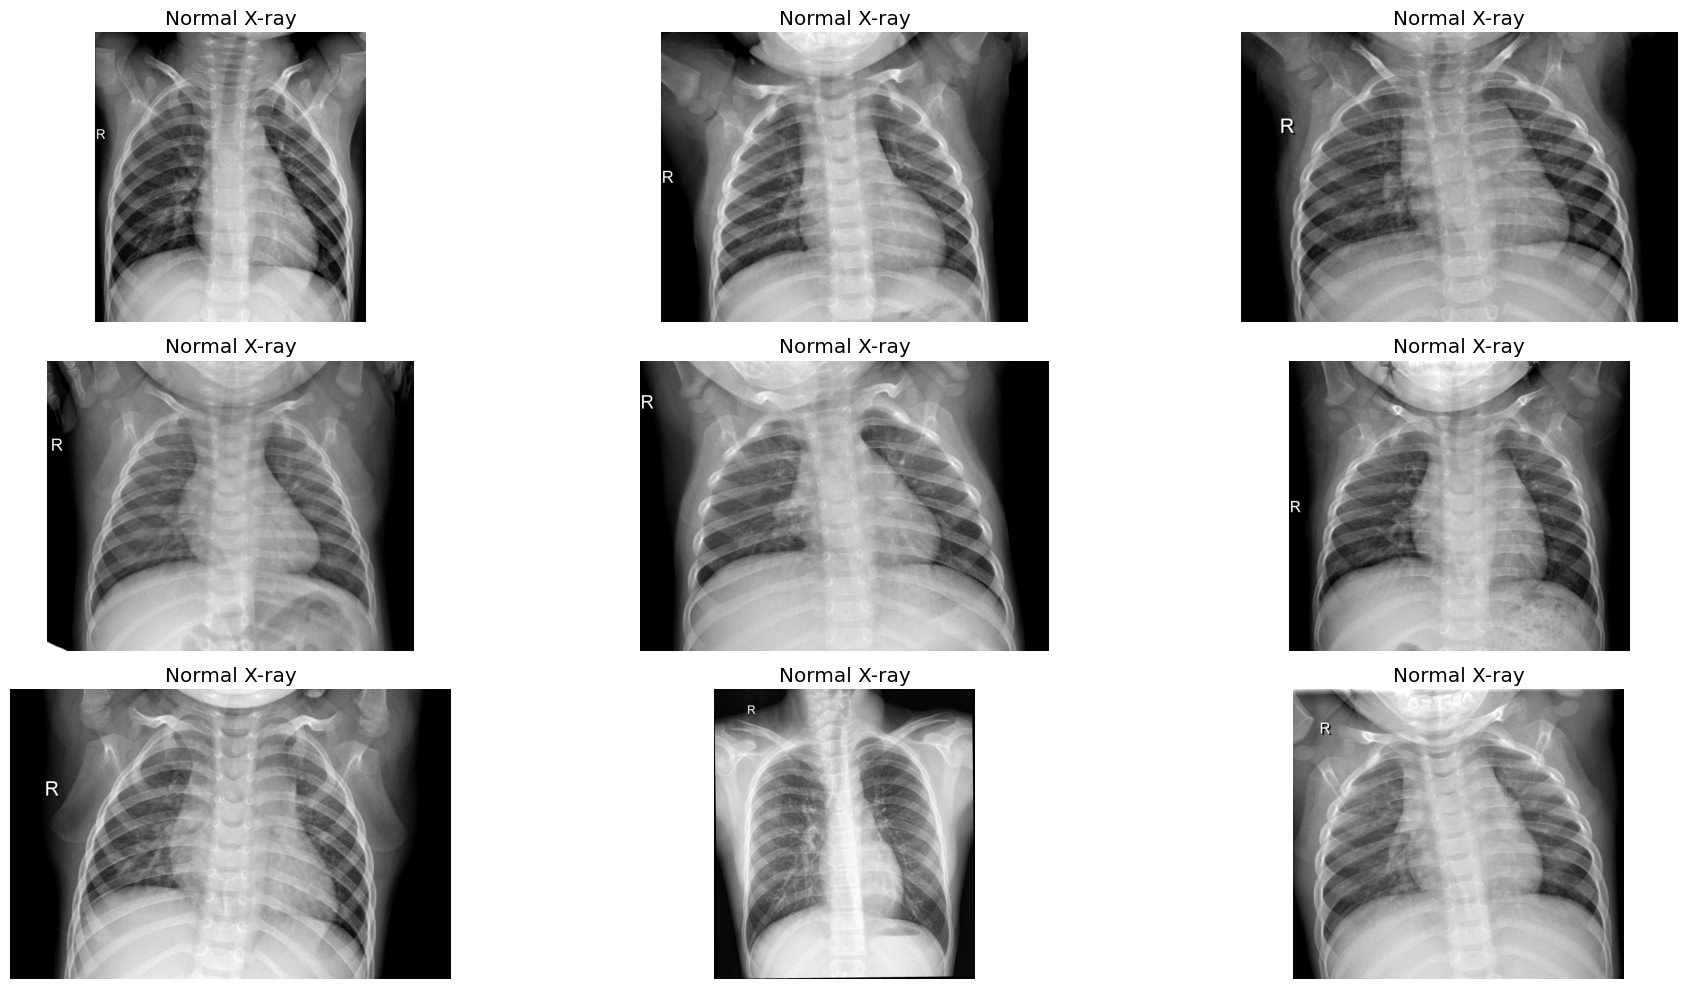

In [19]:
plt.figure(figsize=(20, 10))

for i in range(9):
  plt.subplot(3, 3, i+1)
  img = plt.imread(os.path.join(normal_dir, normal[i]))
  plt.imshow(img, cmap='gray')
  plt.axis('off')
  plt.title("Normal X-ray")

plt.tight_layout()

['Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia', 'Pneumonia'

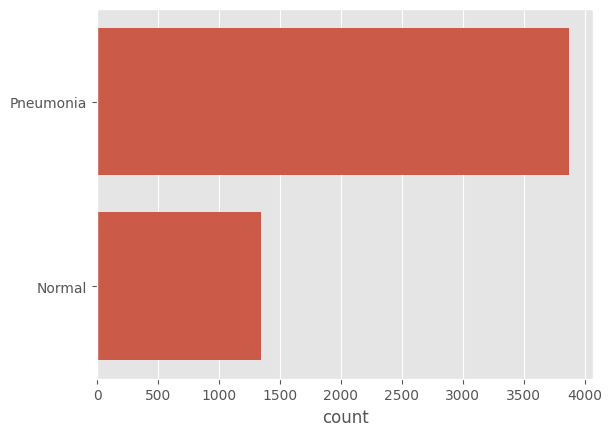

In [20]:
listx = []
for i in train:
  if(i[1]==0):
    listx.append("Pneumonia")
  else:
    listx.append("Normal")
sns.countplot(listx)

print(listx)

In [25]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Dropout
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [26]:
train_datagen = ImageDataGenerator(rescale= 1./255,
                                   horizontal_flip = 0.4,
                                   vertical_flip = 0.4,
                                   rotation_range = 40,
                                   shear_range = 0.2,
                                   width_shift_range=0.4,
                                   height_shift_range=0.4,
                                   fill_mode = "nearest")

valid_datagen = ImageDataGenerator(rescale=1./255)
test_dategen = ImageDataGenerator(rescale=1./255)

In [27]:
train_generator = train_datagen.flow_from_directory("/content/chest-xray-pneumonia/chest_xray/chest_xray/train",
                                                    batch_size = 32,
                                                    target_size = (128, 128),
                                                    class_mode = 'categorical',
                                                    shuffle = True,
                                                    seed = 42,
                                                    color_mode = 'rgb')

valid_generator = valid_datagen.flow_from_directory("/content/chest-xray-pneumonia/chest_xray/chest_xray/val",
                                                    batch_size = 32,
                                                    target_size = (128, 128),
                                                    class_mode = 'categorical',
                                                    shuffle = True,
                                                    seed = 42,
                                                    color_mode = 'rgb')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [28]:
class_labels = train_generator.class_indices
class_labels

{'NORMAL': 0, 'PNEUMONIA': 1}

In [29]:
class_name = {value:key for (key, value) in class_labels.items()}
class_name

{0: 'NORMAL', 1: 'PNEUMONIA'}

In [41]:
base_model = VGG19(input_shape=(128, 128, 3),
                   include_top=False,
                   weights='imagenet')

for layer in base_model.layers:
  layer.trainable = False

x = base_model.output

flat = Flatten()(x)

class_1 = Dense(4608, activation = 'relu')(flat)

dropout = Dropout(0.2)(class_1)

class_2 = Dense(1152, activation='relu')(dropout)

output = Dense(2, activation='softmax')(class_2)

model_01 = Model(base_model.inputs, output)

model_01.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 128, 128, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 64, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 32, 32, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 8, 8, 512)           │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 63,089,602 (240.67 MB)

 Trainable params: 43,065,218 (164.28 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [42]:
filepath = "model.keras"
es = EarlyStopping(monitor="val_loss", verbose = 1, mode = "min", patience = 4)

cp = ModelCheckpoint(filepath, monitor = "val_loss", save_best_only=True, save_weights_only=False,mode="auto", save_freq="epoch")

lrr = ReduceLROnPlateau(monitor = "val_accuracy", patience=3, verbose = 1, factor=0.5, mil_lr = 0.0001)

sgd = SGD(learning_rate = 0.0001, decay = 1e-6, momentum = 0.1, nesterov = True)

model_01.compile(loss = 'categorical_crossentropy', optimizer = sgd, metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [43]:
history_01 = model_01.fit(train_generator,
                          steps_per_epoch = 50,
                          epochs = 10,
                          callbacks = [es, cp, lrr],
                          validation_data = valid_generator
                          )

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 31s 521ms/step - accuracy: 0.5390 - loss: 0.7820 - val_accuracy: 0.5000 - val_loss: 0.9394 - learning_rate: 1.0000e-04
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 503ms/step - accuracy: 0.7366 - loss: 0.5682 - val_accuracy: 0.5000 - val_loss: 0.8963 - learning_rate: 1.0000e-04
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 449ms/step - accuracy: 0.7161 - loss: 0.5758 - val_accuracy: 0.5000 - val_loss: 0.8636 - learning_rate: 1.0000e-04
Epoch 4/10
13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.7208 - loss: 0.5712
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.7353 - loss: 0.5638 - val_accuracy: 0.5000 - val_loss: 0.8545 - learning_rate: 1.0000e-04
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 485ms/step - accuracy: 0.7362 - loss: 0.5380 - val_accuracy: 0.5000 - val_loss: 0.8377 - learning_rate: 5.0000e-05
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 494ms/step - accuracy: 

In [44]:
if not os.path.isdir('model_weights/'):
  os.mkdir("model_weights/")

model_01.save(filepath = "model_weights/vgg19_model_01.h5", overwrite=True)

In [45]:
test_generator = test_dategen.flow_from_directory("/content/chest-xray-pneumonia/chest_xray/chest_xray/test",
                                                    batch_size = 32,
                                                    target_size = (128, 128),
                                                    class_mode = 'categorical',
                                                    shuffle = True,
                                                    seed = 42,
                                                    color_mode = 'rgb')

Found 624 images belonging to 2 classes.


In [46]:
model_01.load_weights("model_weights/vgg19_model_01.h5")

vgg_val_eval_01 = model_01.evaluate(valid_generator)

vagg_test_eval_01 = model_01.evaluate(test_generator)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.5000 - loss: 0.8178
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.6141 - loss: 0.6579


In [47]:
print(f"Validatoin loss: {vgg_val_eval_01[0]}")
print(f"Validation Accuracy: {vgg_val_eval_01[1]}")
print(f"Test Loss: {vagg_test_eval_01[0]}")
print(f"Test Accuracy: {vagg_test_eval_01[1]}")

Validatoin loss: 0.8177879452705383
Validation Accuracy: 0.5
Test Loss: 0.6408986449241638
Test Accuracy: 0.625


In [48]:
from tensorflow.keras.models import load_model

# Load the model
model_path = "/content/model_weights/vgg19_model_01.h5"
model = load_model(model_path)

# Unfreeze all layers (make them trainable)
for layer in model.layers:
    layer.trainable = True

# Check trainable status of layers
for layer in model.layers:
    print(f"Layer: {layer.name}, Trainable: {layer.trainable}")

# Recompile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Save the updated model
model.save("/content/model_weights/unfrozen_vgg19_model.h5")


Layer: input_layer_1, Trainable: True
Layer: block1_conv1, Trainable: True
Layer: block1_conv2, Trainable: True
Layer: block1_pool, Trainable: True
Layer: block2_conv1, Trainable: True
Layer: block2_conv2, Trainable: True
Layer: block2_pool, Trainable: True
Layer: block3_conv1, Trainable: True
Layer: block3_conv2, Trainable: True
Layer: block3_conv3, Trainable: True
Layer: block3_conv4, Trainable: True
Layer: block3_pool, Trainable: True
Layer: block4_conv1, Trainable: True
Layer: block4_conv2, Trainable: True
Layer: block4_conv3, Trainable: True
Layer: block4_conv4, Trainable: True
Layer: block4_pool, Trainable: True
Layer: block5_conv1, Trainable: True
Layer: block5_conv2, Trainable: True
Layer: block5_conv3, Trainable: True
Layer: block5_conv4, Trainable: True
Layer: block5_pool, Trainable: True
Layer: flatten_1, Trainable: True
Layer: dense_3, Trainable: True
Layer: dropout_1, Trainable: True
Layer: dense_4, Trainable: True
Layer: dense_5, Trainable: True
